## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys

In [2]:
sys.path.insert(0, os.getcwd()[:os.getcwd().rfind('\\')])
os.chdir(sys.path[0])

In [3]:
from scripts import Patient, Simulator, Filter
from scripts import base_rule, sd_rule, arv_rule

## Data

In [4]:
df = pd.read_csv('data/diary_param.csv', sep='\t')
df.head()

,patient_id,doctor_id,MeasurementDateStart,MeasurementDateEnd,SystolicPressureMax,SystolicPressureMean,SystolicPressureMin,DiastolicPressureMax,DiastolicPressureMean,DiastolicPressureMin,PulseMax,PulseMean,PulseMin
0,194809,U6VN842K1A,2020-12-07T11:33:00+00:00,2020-12-07T11:33:00+00:00,138.0,138.0,138.0,76.0,76.0,76.0,52.0,52.0,52.0
1,194809,U6VN842K1A,2020-12-08T06:21:00+00:00,2020-12-08T06:21:00+00:00,122.0,122.0,122.0,65.0,65.0,65.0,51.0,51.0,51.0
2,194809,U6VN842K1A,2020-12-09T15:40:00+00:00,2020-12-09T15:40:00+00:00,110.0,110.0,110.0,55.0,55.0,55.0,56.0,56.0,56.0
3,194809,U6VN842K1A,2020-12-10T06:24:00+00:00,2020-12-10T06:24:00+00:00,110.0,110.0,110.0,60.0,60.0,60.0,52.0,52.0,52.0
4,194809,U6VN842K1A,2020-12-11T06:22:00+00:00,2020-12-11T06:22:00+00:00,102.0,102.0,102.0,55.0,55.0,55.0,51.0,51.0,51.0


In [5]:
patients = df.patient_id.unique()
print(f'There are {len(patients)} patients.')

There are 140 patients.


## Experiments

### 1 patient 1 simulation run

In [6]:
pat = patients[0]
df_1 = df[df.patient_id == pat]
df_1.to_csv(f'data/patient_{pat}', sep='\t', index=False)

In [7]:
p = Patient(f'data/patient_{pat}')

In [8]:
n_days = 30
sim = Simulator(p)
sim.run_simulation(n_days)

In [9]:
os.remove(f'data/patient_{pat}')  # don't need it anymore

In [10]:
for meas in sim.measurements:
    print(meas.sbp, meas.dbp)  # -1 is a missing measurement

110 62
103 53
93 70
124 81
146 96
-1 -1
94 68
115 58
110 67
128 90
133 88
138 92
132 72
122 80
106 80
-1 -1
99 47
124 68
132 85
92 69
97 72
119 59
106 66
-1 -1
95 71
129 82
115 65
129 87
138 86
116 73


In [11]:
# it's cool that when sbp (dbp) is -1, the map will be -1 :)
map_values = np.array([(meas.sbp + 2 * meas.dbp) / 3 for meas in sim.measurements])  # MAP is the mean arterial pressure

In [12]:
f = Filter([
            base_rule,
            sd_rule,
            arv_rule,
           ])

In [13]:
f.fit(sim.measurements)
results = f.apply(sim.measurements)[:]

In [14]:
def filter_missing(meas_array, apply_array):
    return np.where(meas_array == -1, None, apply_array)  # -1 is a missing measurement

In [15]:
filtered_vals = filter_missing(map_values, map_values)

In [16]:
def plot_meas_series(vals, checks, title=None):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(vals, 'o--', markersize='4')
    ax.plot(np.where(checks == True, None, vals), 'x', markersize='6', label='alerts')
    ax.set_xlabel('measurement number')
    ax.set_ylabel('MAP')
    ax.set_title(title)
    ax.legend();
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

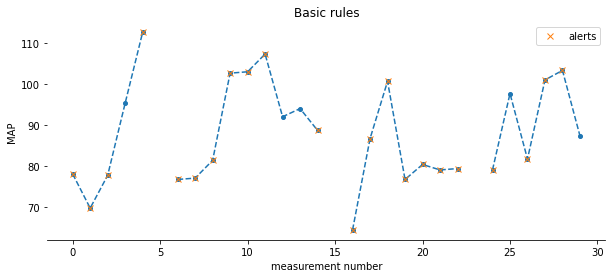

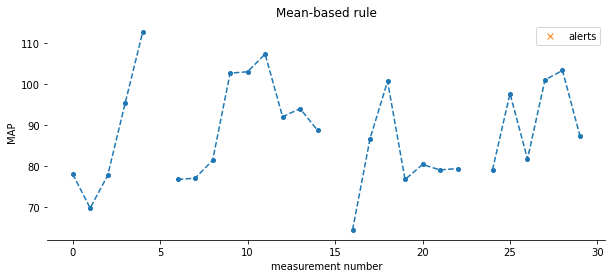

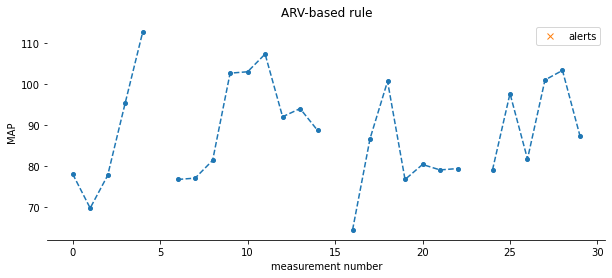

In [17]:
for checks, rule in zip(results, ['Basic rules', 'Mean-based rule', 'ARV-based rule']):
    plot_meas_series(filtered_vals, filter_missing(map_values, checks), rule)

### 1 patient many simulation runs

In [18]:
pat = 194937  # patients[0]
df_1 = df[df.patient_id == pat]
df_1.to_csv(f'data/patient_{pat}', sep='\t', index=False)

In [19]:
p = Patient(f'data/patient_{pat}')

In [20]:
%%time
n_days = 30
sim = Simulator(p)

sim_runs = []
for _ in range(100):
    sim.run_simulation(n_days)
    sim_runs.append(sim.measurements)
    sim.reset_simulation()

Wall time: 12 s


In [21]:
os.remove(f'data/patient_{pat}')  # don't need it anymore

In [22]:
checks = []
for sim_meas in sim_runs:
    f = Filter([
                base_rule,
                sd_rule,
                arv_rule,
               ])
    f.fit(sim_meas)
    checks.append(dict(zip(['base', 'sd', 'arv'], f.apply(sim_meas))))

In [23]:
base_load, sd_load, arv_load = [], [], []

for i, check in enumerate(checks):
    map_values = np.array([(meas.sbp + 2 * meas.dbp) / 3 for meas in sim_runs[i]])
    meas_cnt = (map_values != -1).sum()  # without missing
    base_load.append((filter_missing(map_values, check['base']) == False).sum() / meas_cnt)
    sd_load.append((filter_missing(map_values, check['sd']) == False).sum() / meas_cnt)
    arv_load.append((filter_missing(map_values, check['arv']) == False).sum() / meas_cnt)

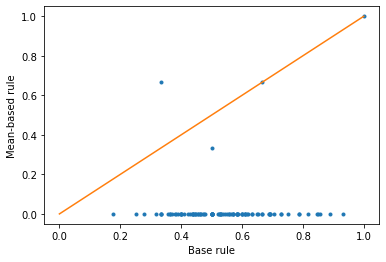

In [24]:
plt.plot(base_load, sd_load, '.')
plt.plot([0,1], [0,1], '-')
plt.xlabel('Base rule')
plt.ylabel('Mean-based rule');

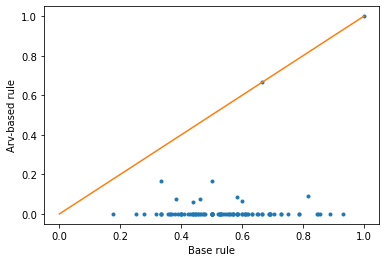

In [25]:
plt.plot(base_load, arv_load, '.')
plt.plot([0,1], [0,1], '-')
plt.xlabel('Base rule')
plt.ylabel('Arv-based rule');